# Machine Learning Internship at Atwomwise

## Solubility of small molecule compounds in DMSO

### Problem description:

Using our internal model for binding affinity, Atomnet, we predict whether a small molecule would bind to a customer protein target. With this method we routinely screen through billions of molecules from libraries of online molecule vendors. These libraries often contain molecules the vendor is confident it can make on order but in many cases they have never actually been made. For our AIMS projects we order and ship the top 100 compounds to our academic partners for them to test wether they actually bind.

Assays for target inhibition (the laboratory test whether a molecule binds to a protein) are usually done with both the compound and the protein dissolved in a solvent called DMSO. When the compounds we order are not soluble or difficult to dissolve in DMSO the test cannot be completed having several negative effects:

 1. We paid for compounds that cannot be used
 2. We loose the opportunity to have our partner test a compound

On the flip side, if we assume a compound is not soluble in DMSO and we decide to take the next compound in the ranked list we potentially mis the opportunity to find a great molecule.

### Provided information:

In the data file `solubility.tsv` you will find three columns of data:

 * mcule_id - A reference ID of the molecule
 * smiles - A string representation of the molecule (https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
 * insoluble - "1" if not soluble, "0" if soluble in DMSO.

See the cells below for how to read the datafile.

### Questions:

 1. Build a model that predicts whether the a molecule is solubile in DMSO
 2. Measure the performance of your predicion model
 3. Make suggestions for how the model could be improved


### Hints:

 * The Python package rdkit contains routines for translating a smiles molecule into various other molecule representations including fingerprints, drawings and physical molecule properties.
 * There is no right or wrong answer, we hope to get a view on how you approach problems and your ability to criticaly discuss your solutions.

In [1]:
import pandas as pd
import numpy as np

## Read the data

In [3]:
df = pd.read_csv('solubility.tsv', header=0, sep="\t")
df.head()

,mcule_id,smiles,insoluble
0,M1114753,O=C([C@H](CC1=CC=CC=C1)N1C(=O)C2=CC=CC=C2C1=O)...,0
1,M1114754,CC1=C(C)CC2C(C1)C(=O)N(C2=O)C1=CC=CC(O)=C1,0
2,M1114755,CC1=C(C)CC2C(C1)C(=O)N(C2=O)C1=CC=C(I)C=C1,0
3,M759494,CCCCN1C(=O)NC2=C(CCC2)C1=O,0
4,M1114756,CC1=NC2=C(S1)C=CC1=C2C=CC2=C1N=C(C)S2,1


## Your Model

#Examine Data

In [4]:
#test whether there are missing values
df.loc[df['mcule_id'].isna()==True]
df.loc[df['smiles'].isna()==True]
df.loc[df['insoluble'].isna()==True]

#check for duplicates
df.loc[df['mcule_id'].duplicated()==True]
df.loc[df['smiles'].duplicated()==True]

#there are no missing values and no dublicates. So I will assume that the input data is correct. 


,mcule_id,smiles,insoluble


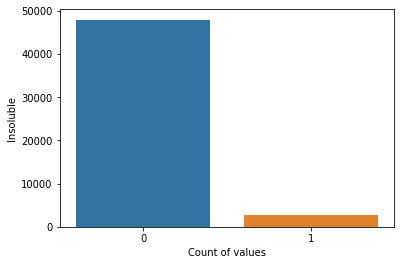

18

In [5]:
#target values count shows that insoluble molecules are severely underrepresented
import seaborn as sns
from matplotlib import pyplot as plt

sns.countplot(data = df, x='insoluble', orient='v')
plt.ylabel('Insoluble')
plt.xlabel('Count of values')
plt.show()

ratio_insol= int(len(df)/len(df.loc[df['insoluble']==1]))
ratio_insol



## Get mol rdkit Object from Smiles encoding which can be used for further processing and extraction of features. 


In [6]:
#Importing Chem module
from rdkit import Chem 
#Method transforms smiles strings to mol rdkit object
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

#save df, so we don't need to reload it in case
df_og=df

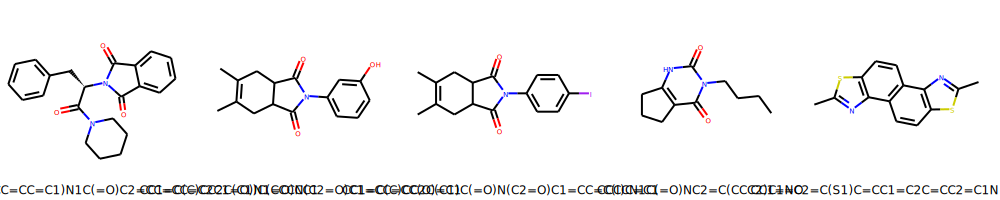

In [124]:
#Draw some Molecules for fun
from rdkit.Chem import Draw
mols = df['mol'][:5]

#MolsToGridImage allows to paint a number of molecules at a time
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(df['smiles'][:5].values))

## Feature Extraction 
We know that solubility of molecules is determined by the distribution of charge in the molecule. 
We know that large molecules are less soluble. 
Polar atoms or atomic groups (such containing O, N, P, S, Br, Cl, F an etc.) contribute towards solubility. 
In fact rdkit even offers to compute the logP value of the molecule. The logP value represents the partition coefficient which measures the solubility of the molecule. So in theory this should be a very good predictor. 

In [7]:
#Calculate different features with rdkit 
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

RDkit supports subpattern search represented by GetSubstructMatches() method. It takes a MOL of a substructure pattern as an argument. So we can  extract every occurance of each pattern we'd like. The method returns a tuple of tuples of positions of corresponding patterns. To extract the number of matches we need to take the length of a corresponding tuple of tuples.

In [8]:
#Features that may be useful could be the number of specific atoms (or groups)
#Many C atoms could indicate lipophilicity
#Cl, N and O indicate hydrophilicity, because of the polar bonds they form 

def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

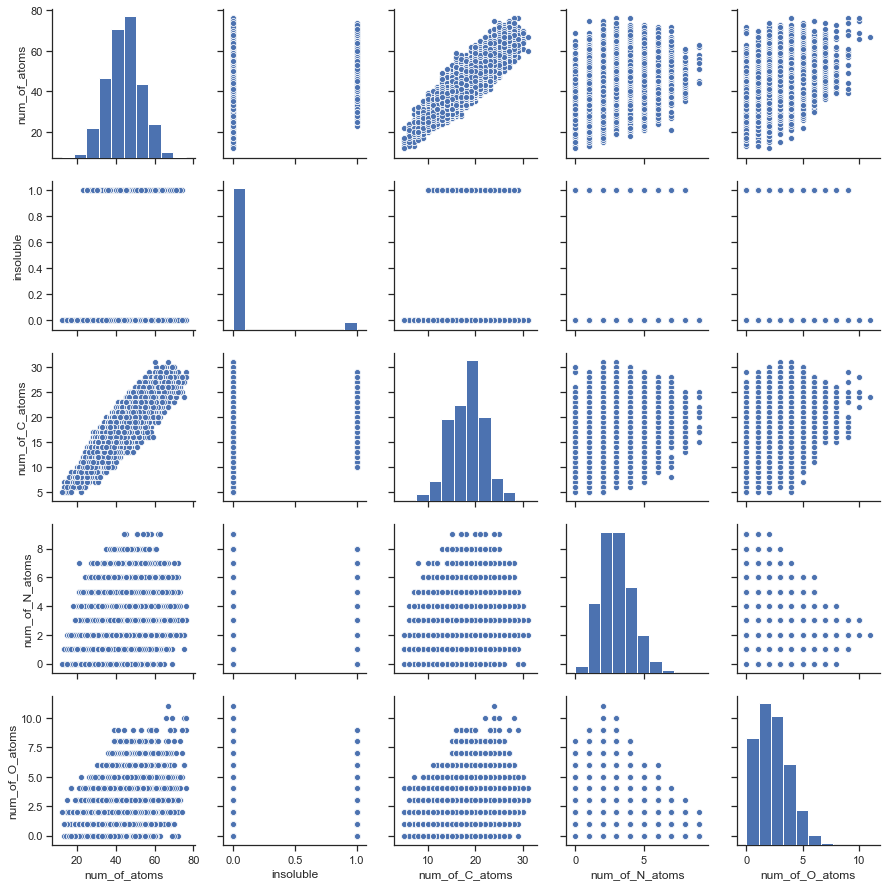

In [127]:
#We can examine visually whether there is a relation in the data between insolubility and the constructed features (by looking at the column of insolubility). 
sns.set(style="ticks", color_codes=True)
sns.pairplot(df[['num_of_atoms', 'insoluble','num_of_C_atoms','num_of_N_atoms', 'num_of_O_atoms']]) #, diag_kind='cor', kind='cor', markers='+')  #
plt.show()

#It can be seen that the insoluble molecules are not very small molecules (larger than 20 atoms approx). They have at least 10 C atoms. The max number of O and N numbers is a bit smaller then in the soluble atoms. But this can also be coincidence due to the lower representation of insoluble molecules. 


# More useful features

Ref: https://www.mdpi.com/1420-3049/24/18/3383/htm 
It has been found in other papers that especially the presence of aromatic rings which are hydrophic contribute to the molecule being insoluble. 
GetRingInfo().NumAtomRings(2))
Likewise the total polar surface area is available (TPSA), as well as the maximum absoluand the logP value through rdkit. 
rdkit.Chem.Descriptors.TPSA() 


In [9]:
from rdkit.Chem import rdMolDescriptors
df['aromatic'] = df['mol'].apply(lambda x: rdMolDescriptors.CalcNumAromaticRings(x))

from  rdkit.Chem import Crippen
df['logp'] = df['mol'].apply(lambda x: Crippen.MolLogP(x))

from rdkit.Chem import Descriptors
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))

atp=df['mol'][0]
atp.GetRingInfo().NumAtomRings(4)
atp.GetIsAromatic()

In [129]:
#df['max_abs_part_charge'] = df['mol'].apply(lambda x: Descriptors.MaxAbsPartialCharge(x))  # im not sure what this means
# df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
# df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
# df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

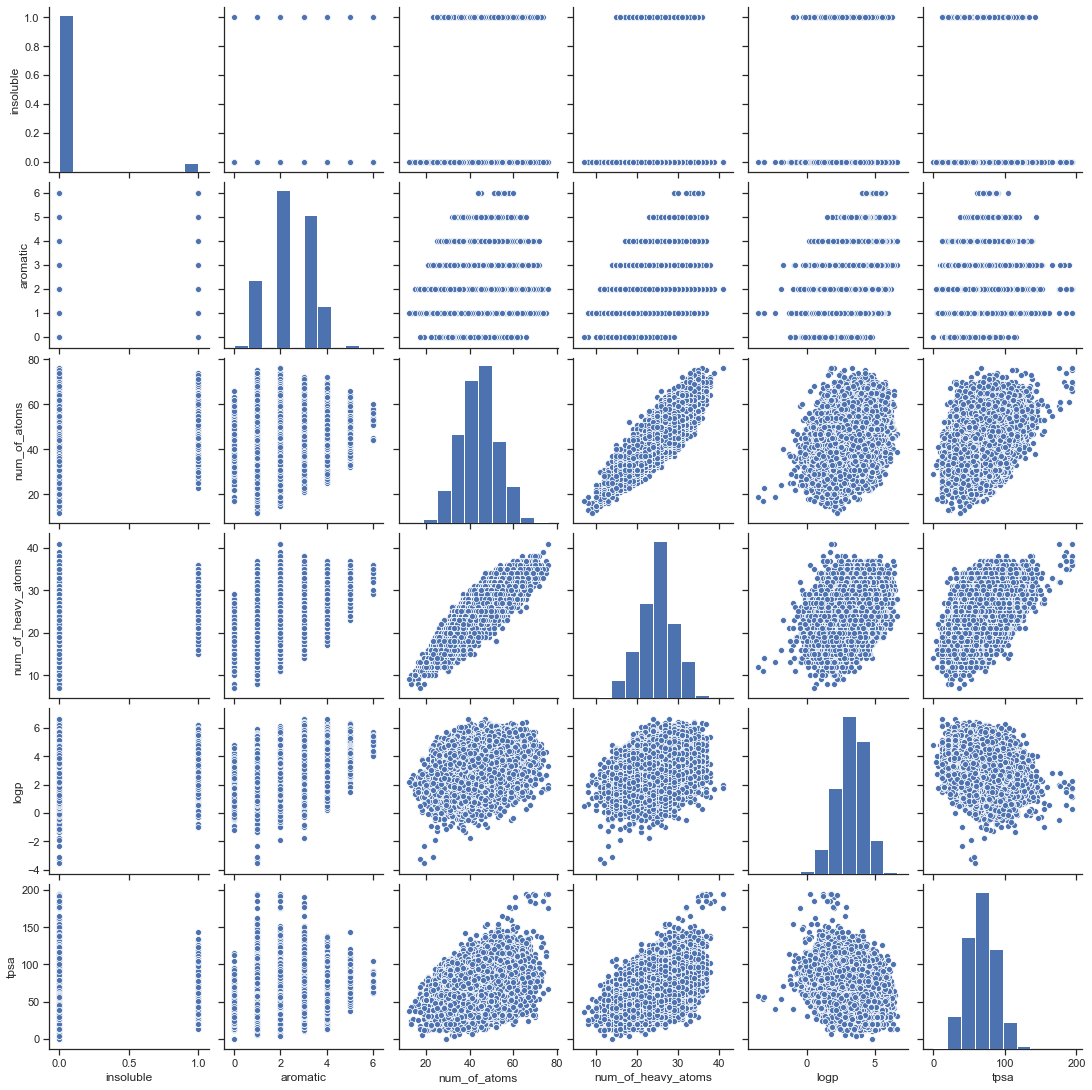

In [11]:
#For the new feature too: We can examine visually whether there is a relation in the data between insolubility and the constructed features (by looking at the column of insolubility). 
sns.set(style="ticks", color_codes=True)
sns.pairplot(df[['insoluble', 'aromatic', 'num_of_atoms', 'num_of_heavy_atoms','logp','tpsa']]) #, diag_kind='cor', kind='cor', markers='+')  #
plt.show()

In [130]:
X_feat= df
X_feat

,mcule_id,smiles,insoluble,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,aromatic,logp,tpsa
0,M1114753,O=C([C@H](CC1=CC=CC=C1)N1C(=O)C2=CC=CC=C2C1=O)...,0,"<img data-content=""rdkit/molecule"" src=""data:i...",49,27,22,3,2,0,2,2.90640,57.69
1,M1114754,CC1=C(C)CC2C(C1)C(=O)N(C2=O)C1=CC=CC(O)=C1,0,"<img data-content=""rdkit/molecule"" src=""data:i...",37,20,16,3,1,0,1,2.62800,57.61
2,M1114755,CC1=C(C)CC2C(C1)C(=O)N(C2=O)C1=CC=C(I)C=C1,0,"<img data-content=""rdkit/molecule"" src=""data:i...",36,20,16,2,1,0,1,3.52700,37.38
3,M759494,CCCCN1C(=O)NC2=C(CCC2)C1=O,0,"<img data-content=""rdkit/molecule"" src=""data:i...",31,15,11,2,2,0,1,0.82540,54.86
4,M1114756,CC1=NC2=C(S1)C=CC1=C2C=CC2=C1N=C(C)S2,1,"<img data-content=""rdkit/molecule"" src=""data:i...",28,18,14,0,2,0,4,4.67604,25.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50615,M1151964,ClC1=CC=C(COC(=O)C2=CC=C3OCOC3=C2)C=C1,0,"<img data-content=""rdkit/molecule"" src=""data:i...",31,20,15,4,0,1,2,3.42570,44.76
50616,M1151965,BrC1=CC=C(C=C1)C(=O)NC1=CC=C(C=C1)C1=CNC=N1,0,"<img data-content=""rdkit/molecule"" src=""data:i...",33,21,16,1,3,0,3,4.09150,57.78
50617,M889510,CC1=CC=C2N(CCCC2=C1)C(=O)C1=COCCO1,0,"<img data-content=""rdkit/molecule"" src=""data:i...",36,19,15,3,1,0,1,2.16242,38.77
50618,M889546,CN(CC1=CC=CO1)C(=O)C1=CN=C(OCC(F)(F)F)C(Cl)=C1,0,"<img data-content=""rdkit/molecule"" src=""data:i...",35,23,14,3,2,1,2,3.54130,55.57


# Mol2Vec
We can also get a word2vec/ mol2vec representation of our molcule, that can be used for the training. 


In [131]:
#Loading pre-trained model via word2vec
from gensim.models import word2vec
model = word2vec.Word2Vec.load('inputs/model_300dim.pkl')

In [132]:
df_m2v= df_og


In [12]:
#there were like 2 ways to do the mol2vec. either you do it like this. then you get an array 
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

df_m2v['sentence'] = df_m2v.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
df_m2v['mol2vec'] = [DfVec(x) for x in sentences2vec(df_m2v['sentence'], model, unseen='UNK')]


X_mol= np.array([x.vec for x in df_m2v['mol2vec']])
X_mol = pd.DataFrame(X_mol)

#y = np.array(df_m2v['insoluble'].astype(int))
X_mol

NameError: name 'df_m2v' is not defined

In [134]:
#now we can either test only X_mol or X_feat or X_all

X_all = pd.concat((X_feat, X_mol), axis=1)
X_all = X_all.drop(['sentence', 'mol2vec'], axis=1)

# Make model part 

In [135]:
y =X_all['insoluble'].values


X_feat= X_feat.drop(columns=['smiles', 'mol', 'mcule_id', 'insoluble', 'mol2vec', 'sentence'])
X_all= X_all.drop(columns=['smiles', 'mol', 'mcule_id', 'insoluble'])


In [136]:
X_all


,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,aromatic,logp,tpsa,0,...,290,291,292,293,294,295,296,297,298,299
0,49,27,22,3,2,0,2,2.90640,57.69,10.640659,...,0.622837,11.673452,2.085327,7.593526,-3.311025,2.013963,-11.264046,-21.948433,-14.701626,11.214068
1,37,20,16,3,1,0,1,2.62800,57.61,6.484990,...,1.091236,9.162841,1.396060,7.079977,-2.303704,1.467104,-8.155276,-17.231737,-11.361647,8.326844
2,36,20,16,2,1,0,1,3.52700,37.38,7.109014,...,1.092451,7.265287,1.372454,6.413476,-2.593614,2.001541,-8.205117,-16.295076,-10.963231,7.507936
3,31,15,11,2,2,0,1,0.82540,54.86,7.330331,...,-0.460093,6.904551,0.668985,3.862756,-1.078292,2.825675,-5.045888,-14.676320,-10.473779,6.860011
4,28,18,14,0,2,0,4,4.67604,25.78,5.245308,...,1.703871,8.508255,5.106545,-1.139008,-0.406402,-0.678097,-9.528767,-10.005212,-11.841537,5.337029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50615,31,20,15,4,0,1,2,3.42570,44.76,6.959331,...,-0.299988,9.624661,4.937638,2.119977,-2.449491,-0.269925,-8.985871,-12.573426,-9.436405,5.939939
50616,33,21,16,1,3,0,3,4.09150,57.78,8.705686,...,-0.866711,9.804689,4.107276,3.445743,-2.274645,1.367042,-8.851659,-14.716365,-11.192117,5.112743
50617,36,19,15,3,1,0,1,2.16242,38.77,6.772467,...,0.703199,9.021964,1.712108,4.595263,-2.189786,1.437723,-10.112238,-16.607389,-9.908236,8.957005
50618,35,23,14,3,2,1,2,3.54130,55.57,9.605921,...,-0.081448,8.290075,6.211286,3.355320,-1.329907,0.210434,-6.039890,-13.354376,-12.995517,4.025961


#For evaluation we can construct a ROC curve and calculate the AUC. We want to strike a balance between not missing a potentially viable compound and wasting money by testing a compound that won't work. ), sensitivity (i.e. true positive rate) and specificity (i.e. true negative
rate)


In [137]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
#The intitial configurations are from Mol2Vec paper on similar task. 
#https://s3-eu-west-1.amazonaws.com/itempdf74155353254prod/5513581/Mol2vec__Unsupervised_Machine_Learning_Approach_with_Chemical_Intuition_v1.pdf

names = ["Logistic Regression", "XGBoost", "Random Forest", ]

DT=  DecisionTreeClassifier( criterion = "entropy", random_state = 100, max_depth = 3, min_samples_leaf = 5, class_weight= "balanced" )
LR= LogisticRegression()
RF=RandomForestClassifier(n_estimators=500, max_features= 'sqrt', class_weight= 'balanced')
XGB=  XGBClassifier(n_estimators= 200, learning_rate=0.1, max_depth= 3)
classifiers=[LR,  XGB, RF]

In [138]:
import copy
from matplotlib.pyplot import *
import sklearn.metrics as metrics

# Specifies feature selection approaches for classification to identify the most important features.

# Forward selection for classification which selects a pre-defined number of features (max_features)
# that show the best accuracy. We assume a decision tree learning for this purpose, but
# this can easily be changed. It returns the best features.

def feature_forward_selection(max_features, X_train, y_train):
    # Start with no features.
    ordered_features = []
    ordered_scores = []
    selected_features = []

    prev_best_perf = 0

    # Select the appropriate number of features.
    for i in range(0, max_features):

        #Determine the features left to select.
        features_left = list(set(X_train.columns) - set(selected_features))
        best_perf = 0
        best_attribute = ''

        # For all features we can still select...
        for f in features_left:
            temp_selected_features = copy.deepcopy(selected_features)
            temp_selected_features.append(f)
            #print(temp_selected_features)

            # Determine the performance of a decision tree learner if we were to add featurs
            clf_fit= DT.fit(X_train[temp_selected_features], y_train)

            perf= evaluation_class( clf_fit, X_test[temp_selected_features], y_test)

            # If the performance is better than what we have seen so far (we aim for high AUC)
            # we set the current feature to the best feature and the same for the best performance.
            
            if perf > best_perf:
                best_perf = perf
                best_feature = f
        # We select the feature with the best performance.
        selected_features.append(best_feature)
        prev_best_perf = best_perf
        ordered_features.append(best_feature)
        ordered_scores.append(best_perf)
    return selected_features, ordered_features, ordered_scores


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
['aromatic', 'num_of_atoms', 'num_of_Cl_atoms', 'logp', 'tpsa', 'num_of_N_atoms', 'num_of_O_atoms', 'num_of_C_atoms', 'num_of_heavy_atoms']
[0.6661538947792873, 0.6886775766149321, 0.6886775

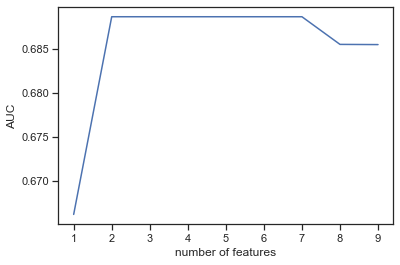

In [139]:
#split data 
#What split do we want to use
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=.20, random_state=1)

#Visualise Results from Feature Selection 
features, ordered_features, ordered_scores = feature_forward_selection(9, X_train, y_train) 
print(ordered_features)
print(ordered_scores)

import matplotlib.pyplot as plot

plot.plot(range(1,10), ordered_scores)
plot.xlabel('number of features')
plot.ylabel('AUC')
plot.show()

In [140]:
X_feat_selected= X_feat[['aromatic', 'num_of_atoms']]

In [141]:
datasets={'X_all': X_all ,'X_feat': X_feat, 'X_feat_selected': X_feat_selected, 'X_mol':X_mol}


Feature selection shows that actually only the first 2 features are used for classification. 

In [142]:
from matplotlib import pyplot as plt
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import roc_curve  #auc, 


def evaluation_class(model, X_test, y_test, make_plot=False):
    prediction = model.predict_proba(X_test)
    preds = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    AUC=roc_auc_score(y_test, preds)
    #AUC = auc(fpr, tpr)  #metrics.auc(y_test, preds)

    
    if make_plot==True:
    
        plt.title('ROC Curve')
        plt.plot(fpr, tpr, 'g', label = 'AUC = %0.3f' % AUC)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        print('ROC AUC score:', round(AUC, 4))
    
    #maybe also save the results of the tesing 
    return AUC

In [143]:
import csv
import pickle
def save_results(dataset_name, clf_name, params, auc):
    data= [[dataset_name, clf_name, params, auc]]
    print(data)
    df= pd.DataFrame(data, columns=['dataset','clf','params','auc'])
    print(df)
    f='results.txt'
    df.to_csv(f, header=True, index=None, mode='a', sep=' ')

    #save model - could also save in evaluation 
    pkl_filename = dataset_name+ "_" + clf_name + ".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

    return df


# Try all algos on X_all dataset

In [144]:
X= X_all
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 100) 

In [145]:
for clf_name, clf in zip(names, classifiers):
    model = clf
    model.fit(X_train, y_train)      
    parameters= model.get_params()
    print(parameters)
    auc= evaluation_class(model, X_test, y_test)   
    print(auc)
    dataset_name= 'X_all'
    save_results(dataset_name, clf_name, parameters, auc)

C:\Users\doyle\Anaconda37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[0 0 0 ... 0 0 1]
0.7974461625466939
[['X_all', 'Logistic Regression', {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}, 0.7974461625466939]]
  dataset                  clf  \
0   X_all  Logistic Regression   

                                              params       auc  
0  {'C': 1.0, 'class_weight': None, 'dual': False...  0.797446  
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_

In [146]:
#Use XGBoost on the different datasets, so delete X_all
data_sets_n= datasets.pop("X_all")


In [147]:
for dataset_name, data in datasets.items():
    dataset_name= dataset_name
    X= data
    print(dataset_name)
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 100) 

    names=["XGBoost"]
    classifiers=[XGB]
    for clf_name, clf in zip(names, classifiers):
        model = clf
        model.fit(X_train, y_train)      
        parameters= model.get_params()
        print(parameters)
        auc= evaluation_class(model, X_test, y_test)   
        print(auc)
        save_results(dataset_name, clf_name, parameters, auc)

X_feat
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 200, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
[0 0 0 ... 0 0 1]
0.7057532778712068
[['X_feat', 'XGBoost', {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 200, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}, 0.7057532778712068]]
  dataset      clf         

## Results

All the results can be found in the results folder in  results.txt. I moved all the saved models and files there, so they won't get overwritten.
I found that the mol2vec representation of the molecule held the most data scoring an AUC of 0.785. The addition of the features from rdkit increased the AUC to 0.788. Only the rdkit features scored an AUC of 0.705. If we only use the 2 best rdkit features which are the number of aromatic rings and number of molecules we obtain a AUC 0.687. These features were also found in similar studies to be most predictive of the insolubility. 

## Future Directions

As a next step, I would implement a Grid search for hyperparameter optimisation of the best scoring algorithm(s). I could not perform this now due to time constaints. 
I also would liked to try out over and undersampling, because of the imbalanced class weights. However I alsready tried to account for this by the usage of the algorithms. I would also like to use stratified k-fold validation. I actually tried this during the model development and saw a big improvement in the AUC values, but it took in the end too long to do this for all the possibilities under the time constraint. 
I wanted to focus on exploring whether the mol2vec data or rdkit features are better for the prediction or if there is a benefit of combinining this data. 

Further, I read in many papers that they are using CNNs for prediciton of chemical properties, for example on the Morgan fingerprint, and a paper even developed a fingerprint based on the SMILES notation.
I also looked into whether I can apply a CNN to the mol2vec data. I think this could be viable and further explored. 

In [148]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

def xgboost(X_train, y_train, X_test):

    # define model
    xgb = XGBClassifier(scale_pos_weight=ratio_insol)
    # define grid
    weights = [100, 1000, 2000]
    param_grid = {}
    param_grid['n_estimators']=weights
    
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
    # define grid search
    grid = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')  
    # execute the grid search
    grid_result = grid.fit(X_train, y_train)
    print(grid.best_params_)
    
    pred_train_y = grid_result.predict(X_train)
    pred_test_y = grid_result.predict(X_test)
    
    return(pred_test_y, pred_train_y)
    

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=.20, random_state=1)
repeats=1
performance_ts_xgb=0
performance_tr_xgb=0

for repeat in range(0, repeats):
        y_pred_test, y_pred_train  = xgboost(X_train, y_train, X_test)
        performance_ts_xgb+= metrics.auc(y_test, y_pred_test, average= "weighted")
        performance_tr_xgb+= metrics.auc(y_train, y_pred_train, average= "weighted")


In [ ]:
performance_ts_xgb
performance_tr_xgb